<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/new_code_SIMPOSIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # BIBLIOTECAS

In [ ]:
pip install open-ephys-python-tools

In [ ]:
! pip install pactools

In [ ]:
from open_ephys.analysis import Session

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

import scipy as sp
from scipy import signal
import math
from scipy.signal import welch, spectrogram, coherence, find_peaks, firwin, lfilter, filtfilt, hilbert
import seaborn as sn

from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from scipy.stats import wilcoxon

import math
import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat

import pactools
from pactools import Comodulogram, REFERENCES

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> # MAPEAMENTO DOS CH DE ACORDO COM IMUNO E VIDEO INSPEÇÃO
# CCM 497
* IL --> ch 1-8
* PRL --> ch 25-32
* CG 2 --> ch 17-24
* CG 1 --> ch 9-16

# CCM 559
* IL --> ficou fora! (1-8)
* PRL --> ch 25-32 e ch 9-16
* CG 2 --> não pegou
* CG1 --> ch 17-24

# DADOS ACELERÔMETRO
* CH 32 - '33': acel_frente(eixo x)
* CH 33 - '34': acel_cima (eixo y)
* CH 34 - '35': acel_lado (eixo z)

# INSPEÇÃO DE VÍDEO

* CCM559_PRE:
  * 11:50 - 12:50 > poucos mov de cabeça
  * 6:07 - 7:53 > quase não se mexe
  * 6:30 - 7:53 > está completamente imóvel
* CCM559_POS:
  * 1:52 - 3:25 > quase não se mexe
  * 3:25 - 4:50 > quase não se mexe
  * 4:50 - 5:50 > quase não se mexe
  * 5:50 - 7:50 > quase não se mexe
  * 7:50 - FINAL > está se limpando

* CCM497_PRE:
  * 4:25 - 5:55 > parado mas se limpa
* CCM497_POS:
  * INÍCIO - 1;40 > completamente imóvel
  * 1:40 - 4:00 > muito parado
  * 5:00 - 8:38 > parado mas se limpa
  * 9:00 - final > parado mas se limpa

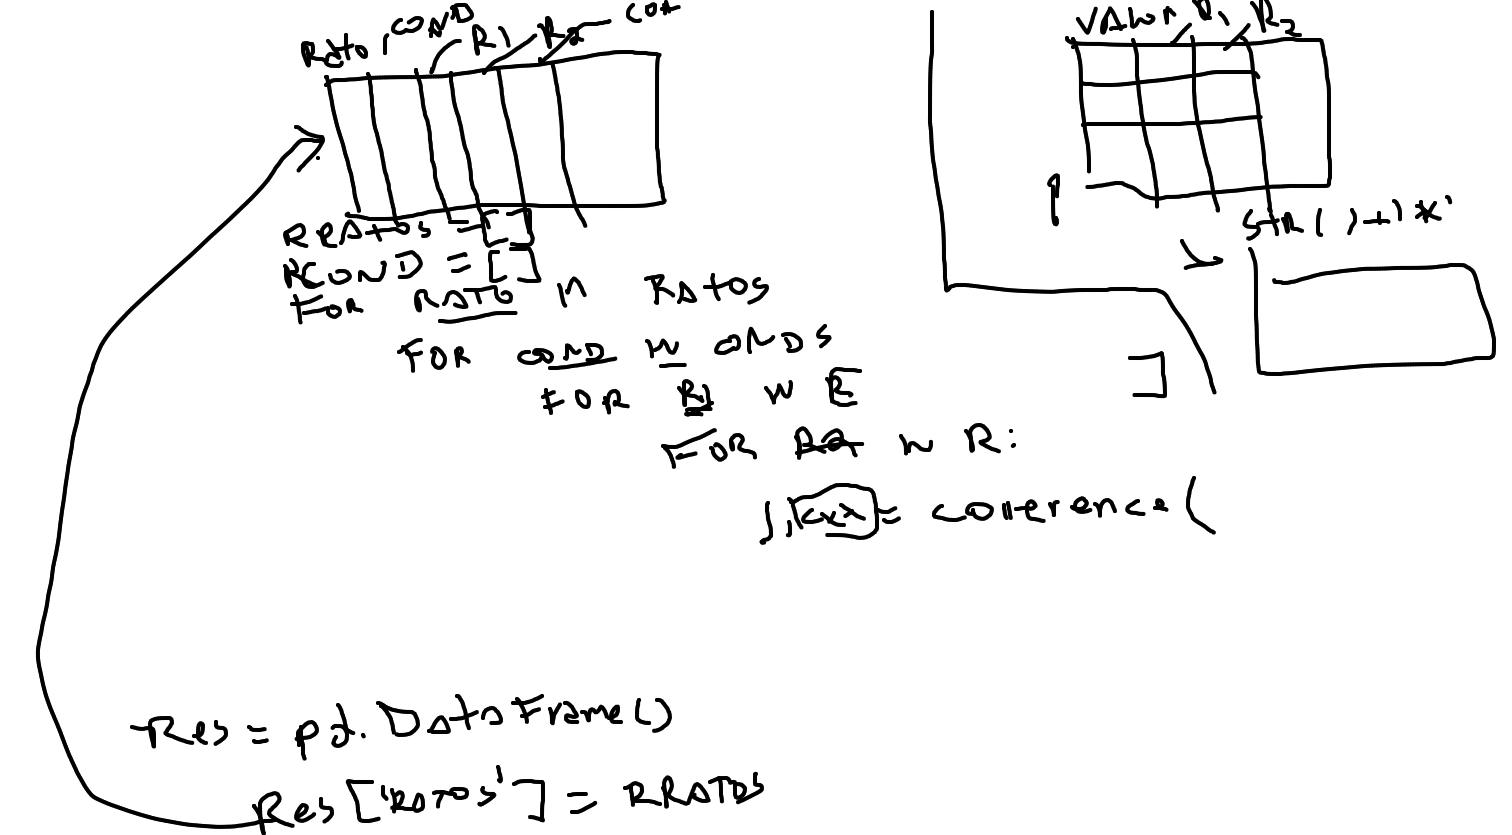

In [ ]:
# ratos = {'CCM497': { 'condicao':{'OF_pre':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pré-screening/CCM497',
#                                'OF_pos':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pós-screening/CCM497'}},
#                       'canais': { 'prl': 30,
#                                   'cg': 9,
#                                   'il': 3},
#          'CCM559': { 'condicao':{'OF_pre':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pré-screening/CCM559',
#                                 'OF_pos':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pós-screening/CCM559'}},
#                       'canais': {'prl': 28,
#                                   'cg': 22,
#                                   'il': 7}}


In [ ]:
ratos = {'CCM497': {'OF_pre':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pré-screening/CCM497',
                  'OF_pos':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pós-screening/CCM497'},

          'CCM559': {'OF_pre':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pré-screening/CCM559',
                  'OF_pos':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pós-screening/CCM559'}}

ch = {'CCM497': {'prl':30,
                 'cg':9},
      'CCM559':{'prl':28,
                'cg':22}}


> # FUNÇÕES



In [ ]:
# CARREGAR O DADO E EXTRAIR MOMENTOS DE IMOBILIDADE

def load_data(path,inicio,final,ch_prl,ch_cg,ch_il):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,ch_prl]
  data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,ch_cg]
  data_il = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,ch_il] #tirei os 10s pq do ccm497 estava com mto ruido

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  CG = signal.filtfilt(b, a, data_cg)
  IL = signal.filtfilt(b, a, data_il)

  return(pd.DataFrame({'data_PRL': PRL,'data_CG': CG, 'data_IL': IL, 'status': 'animal_parado'}))

In [ ]:
def tempo_para_pontos(tempo):
    minutos, segundos = map(int, tempo.split(':'))
    total_segundos = minutos * 60 + segundos
    pontos = total_segundos * 1000
    return pontos

In [ ]:
# FILTRO SIMPLES

def eegfilt(data,srate,flow,fhigh):

    # fir LS
    trans = 0.15
    nyq = srate*0.5
    f=[0, (1-trans)*flow/nyq, flow/nyq, fhigh/nyq, (1+trans)*fhigh/nyq, 1]
    m=[0,0,1,1,0,0]
    filt_order = 3*np.fix(srate/flow)
    if filt_order % 2 == 0:
        filt_order = filt_order + 1

    filtwts = signal.firls(filt_order,f,np.double(m))
    data_filt = signal.filtfilt(filtwts,1, data)

    return(data_filt)

    return(data_filt)

In [ ]:
#ExTRAINDO O MODULATION INDEX

def modulation_index(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)

    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    entrop = -1*(np.sum(p*np.log(p)))
    mi = (np.log(numbin)-entrop)/np.log(numbin)

    return(mi)

In [ ]:
# ACOP FASE AMPL PARA UMA REGIÃO

def pac(lfp,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))

    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))

    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))

    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# ACOP FASE AMPL ENTRE DUAS REGIÕES

def pac_entre_regioes(lfp_alta,lfp_lenta,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_alta,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))


    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp_lenta,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))


    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))


    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

> # ANÁLISE DOS DADOS

In [ ]:
# load_data(path,inicio,final,ch_prl,ch_cg,ch_il)

# CRIANDO DF COM OS DADOS

dataframes = []
for rato in ratos.keys():
  if rato == 'CCM497': #como só são dois ratos eu criei so 1 if, se forem mais criar elifs cm os canais de cada rato
    ch_prl = 30
    ch_cg = 9
    ch_il = 3
  else:
    ch_prl = 28
    ch_cg = 22
    ch_il = 7
  for condicao in ratos[rato].keys():
    if rato == 'CCM497':
      if condicao =='OF_pre':
        inicio = 265000
        final = inicio + 90000
      else:
        inicio = 5000
        final = inicio + 90000
    else:
      if condicao =='OF_pre':
        inicio = 390000
        final = inicio + 90000
      else:
        inicio = 205000
        final = inicio + 90000
    path = ratos[str(rato)][str(condicao)]
    df_temp = load_data(path,inicio,final, ch_prl, ch_cg, ch_il)
    # df_temp = df_temp - np.mean(df_temp)
    df_temp['animal'] = str(rato)
    df_temp['condicao'] = str(condicao)
    dataframes.append(df_temp)

df = pd.concat(dataframes)

/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pré-screening/CCM497/Record Node 101/experiment1/recording1/structure.oebin' mode='r' encoding='UTF-8'>
  self.info = json.load(open(os.path.join(self.directory, 'structure.oebin')))
/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pré-screening/CCM497/Record Node 101/experiment1/recording2/structure.oebin' mode='r' encoding='UTF-8'>
  self.info = json.load(open(os.path.join(self.directory, 'structure.oebin')))
/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/

In [ ]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

,data_PRL,data_CG,data_IL,status,animal,condicao
0,-33.823845,-3.421098,-8.509329,animal_parado,CCM497,OF_pre
1,-25.744481,-20.840633,-13.963871,animal_parado,CCM497,OF_pre
2,-7.907432,-31.926399,-24.771925,animal_parado,CCM497,OF_pre
3,1.564618,-32.944026,-9.333280,animal_parado,CCM497,OF_pre
4,-2.528805,-40.180857,-59.472139,animal_parado,CCM497,OF_pre
...,...,...,...,...,...,...
89995,96.185614,91.524333,81.802936,animal_parado,CCM559,OF_pos
89996,124.944468,111.646882,122.537451,animal_parado,CCM559,OF_pos
89997,137.874349,113.358305,154.309814,animal_parado,CCM559,OF_pos
89998,129.075131,98.258230,177.959850,animal_parado,CCM559,OF_pos


> # COHERENCE

## duvida:

- tem uma forma mais pratica de analizar essas coerencias?
pq vão ter muito mais regiões!!!! vai ficar enorme

In [ ]:
coher_prl_cg_pre = []
coher_prl_cg_pos = []
coher_prl_il_pre = []
coher_prl_il_pos = []
coher_il_cg_pre = []
coher_il_cg_pos = []

for rato in ratos.keys():
    f,cxx_pre = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_PRL'], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_CG'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    coher_prl_cg_pre.append(cxx_pre)

    f,cxx_pos = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_PRL'], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_CG'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    coher_prl_cg_pos.append(cxx_pos)

    f,cx_pre = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_PRL'], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_IL'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    coher_prl_il_pre.append(cx_pre)

    f,cx_pos = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_PRL'], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_IL'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    coher_prl_il_pos.append(cx_pos)

    f,cxx_pre = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_IL'], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_CG'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    coher_il_cg_pre.append(cxx_pre)

    f,cxx_pos = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_IL'], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_CG'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    coher_il_cg_pos.append(cxx_pos)


df_coher = pd.DataFrame({'prl_cg_coher_pre':np.mean(coher_prl_cg_pre,axis = 0), 'prl_cg_coher_pos':np.mean(coher_prl_cg_pos,axis = 0), 'prl_il_coher_pre': np.mean(coher_prl_il_pre,axis = 0), 'prl_il_coher_pos': np.mean(coher_prl_il_pos,axis = 0),
            'il_cg_coher_pre':np.mean(coher_il_cg_pre,axis = 0), 'il_cg_coher_pos':np.mean(coher_il_cg_pos,axis = 0) })


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


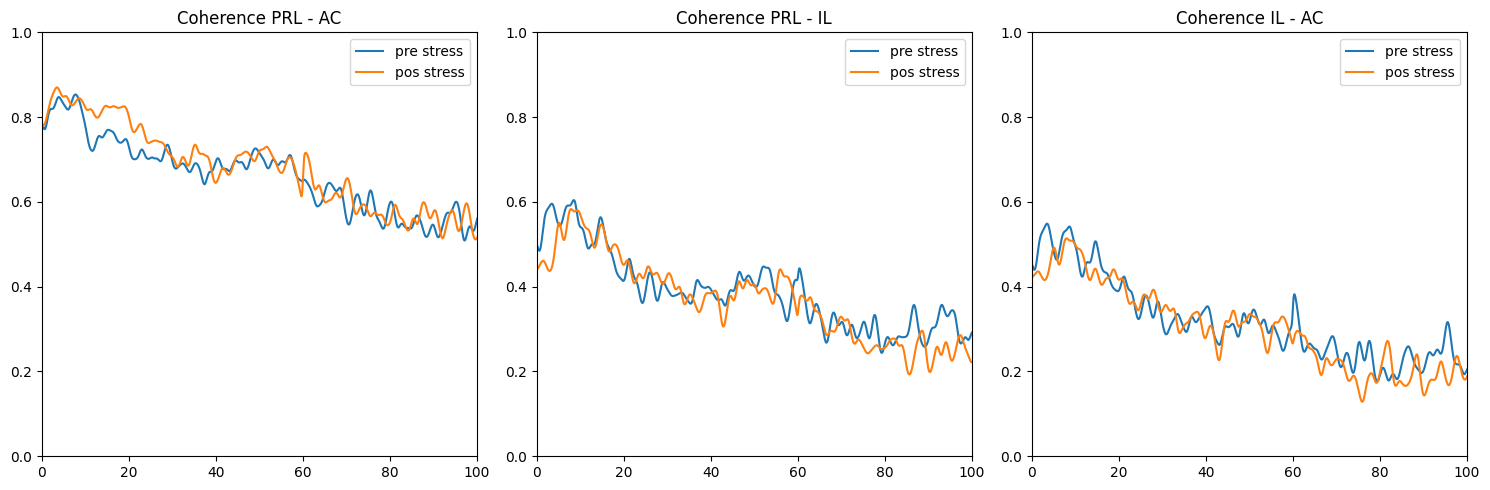

In [ ]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(131)
plt.plot(f,df_coher['prl_cg_coher_pre'], label = 'pre stress')
plt.plot(f, df_coher['prl_cg_coher_pos'], label = 'pos stress')
plt.xlim(0,100)
plt.ylim(0,1)
plt.legend()
plt.title('Coherence PRL - AC' )

ax2 = plt.subplot(132)
plt.plot(f,df_coher['prl_il_coher_pre'], label = 'pre stress')
plt.plot(f, df_coher['prl_il_coher_pos'], label = 'pos stress')
plt.xlim(0,100)
plt.ylim(0,1)
plt.legend()
plt.title('Coherence PRL - IL' )

ax2 = plt.subplot(133)
plt.plot(f,df_coher['il_cg_coher_pre'], label = 'pre stress')
plt.plot(f, df_coher['il_cg_coher_pos'], label = 'pos stress' )
plt.xlim(0,100)
plt.ylim(0,1)
plt.title('Coherence IL - AC' )
plt.legend()
plt.tight_layout()

# > Causalidade de Granger

## qual é o tamanho mínimo que eu posso usar para a causalidade? rodar o dado inteiro estoura a RAM

In [ ]:
# escolhi os primeiros 25000 pontos para calcular a causalidade sem dar crash


lfp_prl_pre = []
lfp_cg_pre = []
lfp_il_pre = []

for rato in ratos.keys():
  prl_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_PRL'][:25000]
  lfp_prl_pre.append(prl_pre)

  cg_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_CG'][:25000]
  lfp_cg_pre.append(cg_pre)

  il_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_IL'][:25000]
  lfp_il_pre.append(il_pre)


lfp_PRL_pre = np.mean(lfp_prl_pre, axis=0)
lfp_CG_pre = np.mean(lfp_cg_pre, axis=0)
lfp_IL_pre = np.mean(lfp_il_pre, axis=0)

In [ ]:
# escolhi 25000 pontos (aleatoriamente) para calcular a causalidade sem dar crash

lfp_prl_pos = []
lfp_cg_pos = []
lfp_il_pos = []

for rato in ratos.keys():
  prl_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_PRL'][:25000]
  lfp_prl_pos.append(prl_pos)

  cg_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_CG'][:25000]
  lfp_cg_pos.append(cg_pos)

  il_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_IL'][:25000]
  lfp_il_pos.append(il_pos)

lfp_PRL_pos = np.mean(lfp_prl_pos, axis=0)
lfp_CG_pos = np.mean(lfp_cg_pos, axis=0)
lfp_IL_pos = np.mean(lfp_il_pos, axis=0)

In [ ]:
# Causalidade de Granger


theta_envelope_prl_pre = np.abs(signal.hilbert(eegfilt(lfp_PRL_pre,1000, 5,10)))
theta_prl_test_pre = np.squeeze(theta_envelope_prl_pre)

theta_envelope_cg_pre = np.abs(signal.hilbert(eegfilt(lfp_CG_pre,1000, 5,10)))
theta_cg_test_pre = np.squeeze(theta_envelope_cg_pre)

theta_envelope_il_pre = np.abs(signal.hilbert(eegfilt(lfp_IL_pre,1000, 5,10)))
theta_il_test_pre = np.squeeze(theta_envelope_il_pre)


matrix_test = np.vstack([np.diff(theta_prl_test_pre),np.diff(theta_cg_test_pre)]).T
lag = [int(math.sqrt(len(matrix_test)))]
gc_theta = grangercausalitytests(matrix_test,lag,verbose = False)
gc_prl_cg_pre = [gc_theta[lag[0]][0]['ssr_ftest'][1],gc_theta[lag[0]][0]['ssr_ftest'][0]]

matrix_test_2 = np.vstack([np.diff(theta_cg_test_pre),np.diff(theta_prl_test_pre)]).T
lag = [int(math.sqrt(len(matrix_test_2)))]
gc_theta_2 = grangercausalitytests(matrix_test_2,lag,verbose = False)
gc_cg_prl_pre = [gc_theta_2[lag[0]][0]['ssr_ftest'][1],gc_theta_2[lag[0]][0]['ssr_ftest'][0]]

matrix_test_3 = np.vstack([np.diff(theta_cg_test_pre),np.diff(theta_il_test_pre)]).T
lag = [int(math.sqrt(len(matrix_test_3)))]
gc_theta_3 = grangercausalitytests(matrix_test_3,lag,verbose = False)
gc_cg_il_pre = [gc_theta_3[lag[0]][0]['ssr_ftest'][1],gc_theta_3[lag[0]][0]['ssr_ftest'][0]]

matrix_test_4 = np.vstack([np.diff(theta_il_test_pre),np.diff(theta_cg_test_pre)]).T
lag = [int(math.sqrt(len(matrix_test_4)))]
gc_theta_4 = grangercausalitytests(matrix_test_4,lag,verbose = False)
gc_il_cg_pre = [gc_theta_4[lag[0]][0]['ssr_ftest'][1],gc_theta_4[lag[0]][0]['ssr_ftest'][0]]

matrix_test_5 = np.vstack([np.diff(theta_prl_test_pre),np.diff(theta_il_test_pre)]).T
lag = [int(math.sqrt(len(matrix_test_5)))]
gc_theta_5 = grangercausalitytests(matrix_test_5,lag,verbose = False)
gc_prl_il_pre = [gc_theta_5[lag[0]][0]['ssr_ftest'][1],gc_theta_5[lag[0]][0]['ssr_ftest'][0]]

matrix_test_6 = np.vstack([np.diff(theta_il_test_pre),np.diff(theta_prl_test_pre)]).T
lag = [int(math.sqrt(len(matrix_test_6)))]
gc_theta_6 = grangercausalitytests(matrix_test_6,lag,verbose = False)
gc_il_prl_pre = [gc_theta_6[lag[0]][0]['ssr_ftest'][1],gc_theta_6[lag[0]][0]['ssr_ftest'][0]]


In [ ]:

theta_envelope_prl_pos = np.abs(signal.hilbert(eegfilt(lfp_PRL_pos,1000, 1,50)))
theta_prl_test_pos = np.squeeze(theta_envelope_prl_pos)

theta_envelope_cg_pos = np.abs(signal.hilbert(eegfilt(lfp_CG_pos,1000, 1,50)))
theta_cg_test_pos = np.squeeze(theta_envelope_cg_pos)

theta_envelope_il_pos = np.abs(signal.hilbert(eegfilt(lfp_IL_pos,1000, 1,50)))
theta_il_test_pos = np.squeeze(theta_envelope_il_pos)


matrix_test_7 = np.vstack([np.diff(theta_prl_test_pos),np.diff(theta_cg_test_pos)]).T
lag = [int(math.sqrt(len(matrix_test_7)))]
gc_theta_7 = grangercausalitytests(matrix_test_7,lag,verbose = False)
gc_prl_cg_pos = [gc_theta_7[lag[0]][0]['ssr_ftest'][1],gc_theta_7[lag[0]][0]['ssr_ftest'][0]]

matrix_test_8 = np.vstack([np.diff(theta_cg_test_pos),np.diff(theta_prl_test_pos)]).T
lag = [int(math.sqrt(len(matrix_test_8)))]
gc_theta_8 = grangercausalitytests(matrix_test_8,lag,verbose = False)
gc_cg_prl_pos = [gc_theta_8[lag[0]][0]['ssr_ftest'][1],gc_theta_8[lag[0]][0]['ssr_ftest'][0]]

matrix_test_9 = np.vstack([np.diff(theta_cg_test_pos),np.diff(theta_il_test_pos)]).T
lag = [int(math.sqrt(len(matrix_test_9)))]
gc_theta_9 = grangercausalitytests(matrix_test_9,lag,verbose = False)
gc_cg_il_pos = [gc_theta_9[lag[0]][0]['ssr_ftest'][1],gc_theta_9[lag[0]][0]['ssr_ftest'][0]]

matrix_test_10 = np.vstack([np.diff(theta_il_test_pos),np.diff(theta_cg_test_pos)]).T
lag = [int(math.sqrt(len(matrix_test_10)))]
gc_theta_10 = grangercausalitytests(matrix_test_10,lag,verbose = False)
gc_il_cg_pos = [gc_theta_10[lag[0]][0]['ssr_ftest'][1],gc_theta_10[lag[0]][0]['ssr_ftest'][0]]

matrix_test_11 = np.vstack([np.diff(theta_prl_test_pos),np.diff(theta_il_test_pos)]).T
lag = [int(math.sqrt(len(matrix_test_11)))]
gc_theta_11 = grangercausalitytests(matrix_test_11,lag,verbose = False)
gc_prl_il_pos = [gc_theta_11[lag[0]][0]['ssr_ftest'][1],gc_theta_11[lag[0]][0]['ssr_ftest'][0]]

matrix_test_12 = np.vstack([np.diff(theta_il_test_pos),np.diff(theta_prl_test_pos)]).T
lag = [int(math.sqrt(len(matrix_test_12)))]
gc_theta_12 = grangercausalitytests(matrix_test_12,lag,verbose = False)
gc_il_prl_pos = [gc_theta_12[lag[0]][0]['ssr_ftest'][1],gc_theta_12[lag[0]][0]['ssr_ftest'][0]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 158, but rank is 152
  warnings.warn('covariance of constraints does not have full '


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


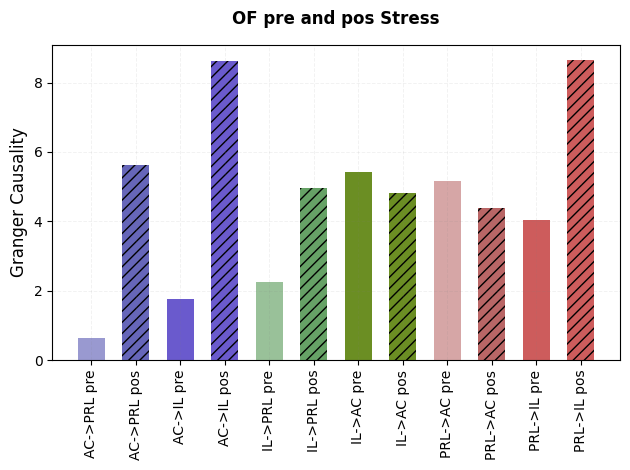

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = ([np.log(np.array(gc_cg_prl_pre[1])), np.log(np.array(gc_cg_prl_pos[1])), np.log(np.array(gc_cg_il_pre[1])), np.log(np.array(gc_cg_il_pos[1])), np.log(np.array(gc_il_prl_pre[1])),
  np.log(np.array(gc_il_prl_pos[1])), np.log(np.array(gc_il_cg_pre[1])), np.log(np.array(gc_il_cg_pos[1])), np.log(np.array(gc_prl_cg_pre[1])), np.log(np.array(gc_prl_cg_pos[1])),
  np.log(np.array(gc_prl_il_pre[1])), np.log(np.array(gc_prl_il_pos[1]))])

labels = ['AC->PRL pre', 'AC->PRL pos' , 'AC->IL pre', 'AC->IL pos', 'IL->PRL pre', 'IL->PRL pos',  'IL->AC pre' ,  'IL->AC pos' ,  'PRL->AC pre', 'PRL->AC pos', 'PRL->IL pre' ,'PRL->IL pos' ]

plt.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.1, axis='both', which='both')

color = ['darkblue', 'darkblue', 'slateblue', 'slateblue', 'darkgreen' ,'darkgreen' ,'olivedrab' ,'olivedrab' ,'darkred', 'darkred','indianred', 'indianred']

hatch_patterns = [ '','///','','///','', '///', '','///','','///','', '///']
alpha = [0.4, 0.6, 1, 1, 0.4, 0.6, 1, 1,0.35, 0.6,1, 1]

# Iterar sobre o número de dados e criar as barras
for i in range(len(data)):
    plt.bar(i+1, data[i], width=0.6, color=color[i], hatch=hatch_patterns[i], align='center', alpha=alpha[i])
    # plt.text(i+1, data[i]+0.1, '***', color='k', fontsize=8, horizontalalignment='center')
plt.title('OF pre and pos Stress', pad=15, fontweight = 'bold')
plt.ylabel('Granger Causality', fontsize=12)

plt.xticks(range(1,13), labels, fontsize=10, rotation=90)

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/gc_pre_pos.jpeg')

plt.show()


In [ ]:
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.6514233940708828,
 5.62296337690926,
 1.759567343211805,
 8.629850774297578,
 2.2534749431655077,
 4.949560025685116,
 5.417544594324103,
 4.81805452102671,
 5.169064480986061,
 4.392911300392957,
 4.052286320034049,
 8.65318594739296]

# FIG 1: PSD 0-100HZ pre-pos

## duvida:

- mesma dúvida da coerencia, tem uma forma mais pratica de fazer? vão ter mais regiões, seria bom simplificar

In [ ]:
#para fazer essa figura o parametro nperseg fou ajustado para 300 para suavizar o gráfico

power_prl_pre = []
power_prl_pos = []
power_cg_pre = []
power_cg_pos = []
power_il_pre = []
power_il_pos = []

for rato in ratos.keys():
    f, p_prl_pre = welch(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_PRL'], fs = 1000,nperseg = 300, noverlap = int(0.9*300), nfft = 10*1000)
    power_prl_pre.append(p_prl_pre)

    f, p_prl_pos = welch(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_PRL'], fs = 1000,nperseg = 300, noverlap = int(0.9*300),nfft = 10*1000)
    power_prl_pos.append(p_prl_pos)

    f, p_cg_pre = welch(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_CG'],fs = 1000,nperseg = 300, noverlap = int(0.9*300),nfft = 10*1000)
    power_cg_pre.append(p_cg_pre)

    f, p_cg_pos = welch(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_CG'], fs = 1000,nperseg = 300, noverlap = int(0.9*300),nfft = 10*1000)
    power_cg_pos.append(p_cg_pos)

    f, p_il_pre = welch(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_IL'], fs = 1000,nperseg = 300, noverlap = int(0.9*300),nfft = 10*1000)
    power_il_pre.append(p_il_pre)

    f, p_il_pos = welch(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_IL'], fs = 1000,nperseg = 300, noverlap = int(0.9*300),nfft = 10*1000)
    power_il_pos.append(p_il_pos)


In [ ]:
df_welch_pre = pd.DataFrame({'mean_power_prl':(np.mean(power_prl_pre,axis = 0)*f), 'mean_power_cg':(np.mean(power_cg_pre,axis = 0)*f), 'mean_power_il': (np.mean(power_il_pre,axis = 0)*f), 'f':f})
df_welch_pos = pd.DataFrame({'mean_power_prl':(np.mean(power_prl_pos,axis = 0)*f), 'mean_power_cg':(np.mean(power_cg_pos,axis = 0)*f), 'mean_power_il': (np.mean(power_il_pos,axis = 0)*f), 'f':f})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


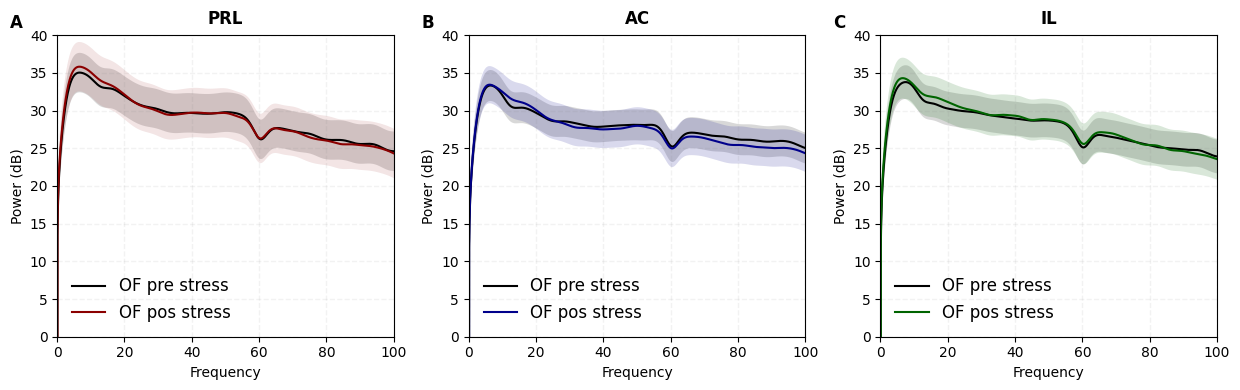

In [ ]:
figura = plt.figure(figsize=(12.5,4))
# figura.suptitle('PSD OF pre and pos stress session', fontweight ="bold", fontsize = 12)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
ax1 = figura.add_subplot(131)
ax1.text(-0.14, 1.07, "A", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")
x = df_welch_pre['f']
y_prl = 10 * np.log10(df_welch_pre['mean_power_prl'] + 1e-10) #aqui foi adicionado uma constante para eliminar valores negativos do calculo e conseguir calcular o std
std = np.std(y_prl)/np.sqrt(2)  # Cálculo do desvio padrão

x_pos = df_welch_pos['f']
y_pos_prl = 10 * np.log10(df_welch_pos['mean_power_prl'] + 1e-10)
std_pos = np.std(y_pos_prl)/np.sqrt(2)

plt.plot(x, y_prl, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='OF pos stress')
plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=12, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(0,100)
plt.ylim(0,40)

plt.title('PRL', fontweight='bold',  pad = 8, fontsize = 12)

ax2 = figura.add_subplot(132)
ax2.text(-0.14, 1.07, "B", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

x = df_welch_pre['f']
y_cg = 10 * np.log10(df_welch_pre ['mean_power_cg'] + 1e-10)
std_cg = np.std(y_cg)/np.sqrt(2)  # Cálculo do desvio padrão

x_pos = df_welch_pos['f']
y_pos_cg = 10 * np.log10(df_welch_pos ['mean_power_cg'] + 1e-10)
std_pos_cg = np.std(y_pos_cg)/np.sqrt(2)


plt.plot(x, y_cg, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_cg - std_cg, y_cg + std_cg, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='OF pos stress')
plt.fill_between(x_pos, y_pos_cg - std_pos_cg, y_pos_cg + std_pos_cg, color='darkblue', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=12, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(0,100)
plt.ylim(0,40)
plt.title('AC', fontweight='bold',  pad = 8, fontsize = 12)

ax3 = figura.add_subplot(133)
ax3.text(-0.14, 1.07, "C", transform=ax3.transAxes, fontsize=12, fontweight="bold", va="top")
x = df_welch_pre['f']
y_il = 10 * np.log10(df_welch_pre ['mean_power_il'] + 1e-10)
std_il = np.std(y_il)/np.sqrt(2)  # Cálculo do desvio padrão

x_pos = df_welch_pos['f']
y_pos_il = 10 * np.log10(df_welch_pos ['mean_power_il'] + 1e-10)
std_pos_il = np.std(y_pos_il)/np.sqrt(2)


plt.plot(x, y_il, linewidth=1.5, color='k', label='OF pre stress')
plt.fill_between(x, y_il - std_il, y_il + std_il, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_il, linewidth=1.5, color='darkgreen', label='OF pos stress')
plt.fill_between(x_pos, y_pos_il - std_pos_il, y_pos_il + std_pos_il, color='darkgreen', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=12, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(0,100)
plt.ylim(0,40)
plt.title('IL', fontweight='bold',  pad = 8, fontsize = 12)

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/psd_0_100_pre_pos.jpeg')

plt.show()

> # FIG 2: THETA PSD

## duvida:

- para tirar o espectro do theta, eu filtro o dado em theta antes?? ou pega a faixa theta do welch?

- qual variável é utilizada para plotar na barra?

- qual estatística eu posso fazer? wilcoxon? student?

In [ ]:
power_prl_pre = []
power_prl_pos = []
power_cg_pre = []
power_cg_pos = []
power_il_pre = []
power_il_pos = []

for rato in ratos.keys():
    p1 = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_PRL']
    f, p_prl_pre = welch(p1, fs = 1000, nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
    power_prl_pre.append(p_prl_pre)

    p2 = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_PRL']
    f, p_prl_pos = welch(p2, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
    power_prl_pos.append(p_prl_pos)

    p3 = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_CG']
    f, p_cg_pre = welch(p3, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
    power_cg_pre.append(p_cg_pre)

    p4 = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_CG']
    f, p_cg_pos = welch(p4, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
    power_cg_pos.append(p_cg_pos)

    p5 =  df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_IL']
    f, p_il_pre = welch(p5, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
    power_il_pre.append(p_il_pre)

    p6 = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_IL']
    f, p_il_pos = welch( p6, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
    power_il_pos.append(p_il_pos)

In [ ]:
df_welch_pre = pd.DataFrame({'mean_power_prl':(np.mean(power_prl_pre,axis = 0)), 'mean_power_cg':(np.mean(power_cg_pre,axis = 0)), 'mean_power_il': (np.mean(power_il_pre,axis = 0)), 'f':f})
df_welch_pos = pd.DataFrame({'mean_power_prl':(np.mean(power_prl_pos,axis = 0)), 'mean_power_cg':(np.mean(power_cg_pos,axis = 0)), 'mean_power_il': (np.mean(power_il_pos,axis = 0)), 'f':f})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


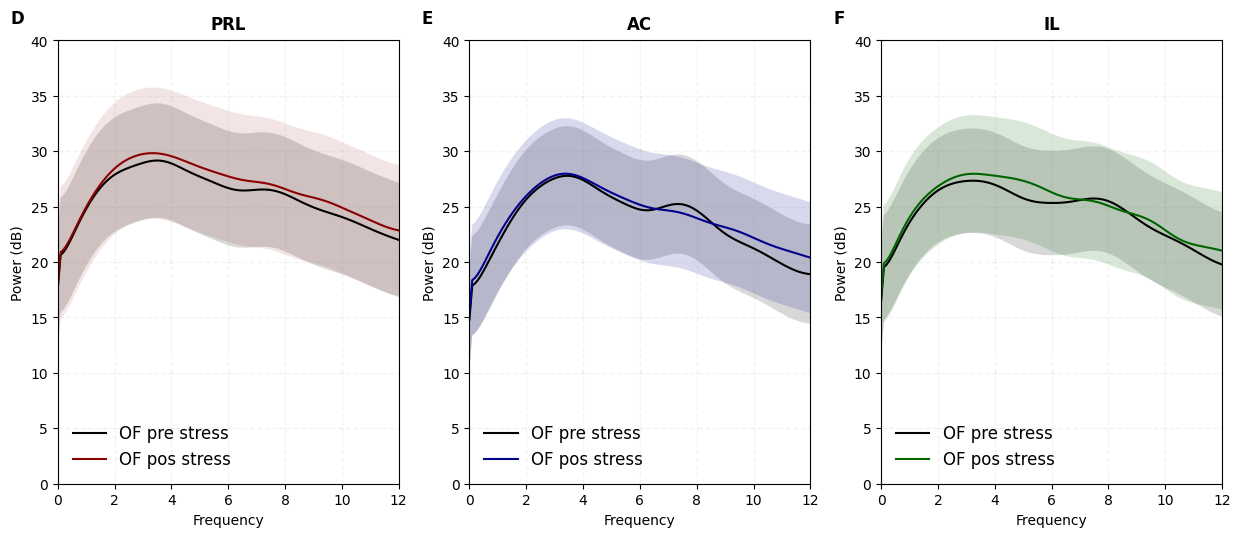

In [ ]:
figura = plt.figure(figsize=(12.5,10))
# figura.suptitle('PSD OF pre and pos screening', fontweight ="bold", fontsize = 12)
gs = gridspec.GridSpec(2, 3)


ax1 = figura.add_subplot(gs[0, 0])
ax1.text(-0.14, 1.07, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")
x = f
y_prl = 10 * np.log10(df_welch_pre['mean_power_prl'] )
std = np.std(y_prl)/np.sqrt(2)

x_pos = f
y_pos_prl = 10 * np.log10(df_welch_pos['mean_power_prl'])
std_pos = np.std(y_pos_prl)/np.sqrt(2)

plt.plot(x, y_prl, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='OF pos stress')
plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=12, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(0,12)
plt.ylim(0,40)

plt.title('PRL', fontweight='bold',  pad = 8, fontsize = 12)

ax2 = figura.add_subplot(gs[0, 1])
ax2.text(-0.14, 1.07, "E", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

x = f
y_cg = 10 * np.log10(df_welch_pre['mean_power_cg'])
std_cg = np.std(y_cg)/np.sqrt(2)  # Cálculo do desvio padrão

x_pos = f
y_pos_cg = 10 * np.log10(df_welch_pos['mean_power_cg'])
std_pos_cg = np.std(y_pos_cg)/np.sqrt(2)


plt.plot(x, y_cg, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_cg - std_cg, y_cg + std_cg, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='OF pos stress')
plt.fill_between(x_pos, y_pos_cg - std_pos_cg, y_pos_cg + std_pos_cg, color='darkblue', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=12, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(0,12)
plt.ylim(0,40)
plt.title('AC', fontweight='bold',  pad = 8, fontsize = 12)

ax3 = figura.add_subplot(gs[0, 2])
ax3.text(-0.14, 1.07, "F", transform=ax3.transAxes, fontsize=12, fontweight="bold", va="top")


x = f
y_il = 10 * np.log10(df_welch_pre['mean_power_il'])
std_il = np.std(y_il)/np.sqrt(2)  # Cálculo do desvio padrão

x_pos = f
y_pos_il = 10 * np.log10(df_welch_pos['mean_power_il'])
std_pos_il = np.std(y_pos_il)/np.sqrt(2)


plt.plot(x, y_il, linewidth=1.5, color='k', label='OF pre stress')
plt.fill_between(x, y_il - std_il, y_il + std_il, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_il, linewidth=1.5, color='darkgreen', label='OF pos stress')
plt.fill_between(x_pos, y_pos_il - std_pos_il, y_pos_il + std_pos_il, color='darkgreen', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=12, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(0,12)
plt.ylim(0,40)
plt.title('IL', fontweight='bold',  pad = 8, fontsize = 12)



# ax4 = figura.add_subplot(gs[1, :])

# ax4.text(-0.04, 1.1, "G", transform=ax4.transAxes, fontsize=12, fontweight="bold", va="top")

# plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')


# reg = (y_prl,y_pos_prl, y_cg, y_pos_cg, y_il, y_pos_il)

# labels = ['PRL pre ', 'PRL pos','AC pre', 'AC pos', 'IL pre', 'IL pos' ]

# plt.grid(color='grey', linestyle='--', linewidth=0.7 ,alpha = 0.1, axis = 'both', which = 'Both')

# color=[ 'grey', 'darkred', 'grey' ,'darkblue' ,'grey', 'darkgreen']

# # Criar as barras com hachura

# for i in range(len(reg)):
#     plt.bar(labels[i], reg[i], width=0.6,color=color[i],  align='center', alpha=0.4)

# # plt.plot([0, 1], [38.5, 38.5], 'k-', linewidth=1.5)
# # plt.plot([0, 0], [38.5, 37.5], 'k-', linewidth=1.5)
# # plt.plot([1, 1], [38.5, 37.5], 'k-', linewidth=1.5)
# # plt.text(0.5, 39, '* * *', color='k', fontsize=12, horizontalalignment='center')

# # plt.plot([2, 3], [36, 36], 'k-', linewidth=1.5)
# # plt.plot([2, 2], [36, 35], 'k-', linewidth=1.5)
# # plt.plot([3, 3], [36, 35], 'k-', linewidth=1.5)

# # # plt.text(2.5, 36.5, '* * *', color='k', fontsize=12, horizontalalignment='center')

# # plt.plot([4, 5], [34.5, 34.5], 'k-', linewidth=1.5)
# # plt.plot([4, 4], [34.5, 33.5], 'k-', linewidth=1.5)
# # plt.plot([5, 5], [34.5, 33.5], 'k-', linewidth=1.5)

# # plt.text(4.5, 35, '* * *', color='k', fontsize=12, horizontalalignment='center')

# # plt.legend(fontsize=12, loc='upper right', frameon=False)
# plt.title('Theta Power', fontweight='bold', pad=6, fontsize=12)
# plt.ylim(50,75)
# plt.ylabel('Power (dB)')
# plt.xticks(fontsize=12, rotation=45)


plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/theta_pre_pos.jpeg')
plt.show()

In [ ]:

# power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 12 )]['mean_power_prl'])
# power_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 12 )]['mean_power_prl'])

# power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 12 )]['mean_power_cg'])
# power_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 12 )]['mean_power_cg'])

# power_il_pre = ( df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 12 )]['mean_power_il'])
# power_il_pos = ( df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 12 )]['mean_power_il'])

# delta_power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 4 )]['mean_power_prl'])
# delta_power_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 4 )]['mean_power_prl'])

# delta_power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 4 )]['mean_power_cg'])
# delta_power_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 4 )]['mean_power_cg'])

# delta_power_il_pre = ( df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 4 )]['mean_power_il'])
# delta_power_il_pos = ( df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 4 )]['mean_power_il'])

# theta_power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 5 ) & (df_welch_pre['f'] <= 10 )]['mean_power_prl'])
# theta_power_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 5 ) & (df_welch_pos['f'] <= 10 )]['mean_power_prl'])

# theta_power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 5 ) & (df_welch_pre['f'] <= 10 )]['mean_power_cg'])
# theta_power_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 5 ) & (df_welch_pos['f'] <= 10 )]['mean_power_cg'])

# theta_power_il_pre = ( df_welch_pre[(df_welch_pre['f'] >= 5 ) & (df_welch_pre['f'] <= 10 )]['mean_power_il'])
# theta_power_il_pos = ( df_welch_pos[(df_welch_pos['f'] >= 5 ) & (df_welch_pos['f'] <= 10 )]['mean_power_il'])


In [ ]:
# figura = plt.figure(figsize=(12.5,10))
# # figura.suptitle('PSD OF pre and pos screening', fontweight ="bold", fontsize = 12)
# gs = gridspec.GridSpec(2, 3)
# ax1 = figura.add_subplot(gs[0, 0])
# ax1.text(-0.14, 1.07, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")
# x = df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 12 )]['f']
# y_prl = 10 * np.log10(power_prl_pre)
# std = np.std(y_prl)/np.sqrt(2)

# x_pos = df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 12 )]['f']
# y_pos_prl = 10 * np.log10(power_prl_pos)
# std_pos = np.std(y_pos_prl)/np.sqrt(2)

# plt.plot(x, y_prl, linewidth=1.5, color='black', label='OF pre stress')
# plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

# plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='OF pos stress')
# plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


# plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
# plt.legend(fontsize=12, loc='lower left', frameon=False)
# plt.xlabel('Frequency')
# plt.ylabel('Power (dB)')
# # plt.xlim(5,10)
# # plt.ylim(26,40)

# plt.title('PRL', fontweight='bold',  pad = 8, fontsize = 12)

# ax2 = figura.add_subplot(gs[0, 1])
# ax2.text(-0.14, 1.07, "E", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

# x = df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 12 )]['f']
# y_cg = 10 * np.log10(power_cg_pre)
# std_cg = np.std(y_cg)/np.sqrt(2)  # Cálculo do desvio padrão

# x_pos = df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 12 )]['f']
# y_pos_cg = 10 * np.log10(power_cg_pos)
# std_pos_cg = np.std(y_pos_cg)/np.sqrt(2)


# plt.plot(x, y_cg, linewidth=1.5, color='black', label='OF pre stress')
# plt.fill_between(x, y_cg - std_cg, y_cg + std_cg, color='gray', alpha=0.3, edgecolor=None)

# plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='OF pos stress')
# plt.fill_between(x_pos, y_pos_cg - std_pos_cg, y_pos_cg + std_pos_cg, color='darkblue', alpha=0.15, edgecolor=None)


# plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
# plt.legend(fontsize=12, loc='lower left', frameon=False)
# plt.xlabel('Frequency')
# plt.ylabel('Power (dB)')
# # plt.xlim(5,10)
# # plt.ylim(26,40)
# plt.title('AC', fontweight='bold',  pad = 8, fontsize = 12)

# ax3 = figura.add_subplot(gs[0, 2])
# ax3.text(-0.14, 1.07, "F", transform=ax3.transAxes, fontsize=12, fontweight="bold", va="top")
# x = df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 12 )]['f']
# y_il = 10 * np.log10(power_il_pre)
# std_il = np.std(y_il)/np.sqrt(2)  # Cálculo do desvio padrão

# x_pos = df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 12 )]['f']
# y_pos_il = 10 * np.log10(power_il_pos)
# std_pos_il = np.std(y_pos_il)/np.sqrt(2)


# plt.plot(x, y_il, linewidth=1.5, color='k', label='OF pre stress')
# plt.fill_between(x, y_il - std_il, y_il + std_il, color='gray', alpha=0.3, edgecolor=None)

# plt.plot(x_pos, y_pos_il, linewidth=1.5, color='darkgreen', label='OF pos stress')
# plt.fill_between(x_pos, y_pos_il - std_pos_il, y_pos_il + std_pos_il, color='darkgreen', alpha=0.15, edgecolor=None)


# plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
# plt.legend(fontsize=12, loc='lower left', frameon=False)
# plt.xlabel('Frequency')
# plt.ylabel('Power (dB)')
# # plt.xlim(5,10)
# # plt.ylim(26,40)
# plt.title('IL', fontweight='bold',  pad = 8, fontsize = 12)

# ax4 = figura.add_subplot(gs[1, :])

# ax4.text(-0.04, 1.1, "G", transform=ax4.transAxes, fontsize=12, fontweight="bold", va="top")

# plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')


# reg = (y_prl,y_pos_prl, y_cg, y_pos_cg, y_il, y_pos_il)

# labels = ['PRL pre ', 'PRL pos','AC pre', 'AC pos', 'IL pre', 'IL pos' ]

# plt.grid(color='grey', linestyle='--', linewidth=0.7 ,alpha = 0.1, axis = 'both', which = 'Both')

# color=[ 'grey', 'darkred', 'grey' ,'darkblue' ,'grey', 'darkgreen']

# # Criar as barras com hachura

# for i in range(len(reg)):
#     plt.bar(labels[i], reg[i], width=0.6,color=color[i],  align='center', alpha=0.4)

# plt.plot([0, 1], [38.5, 38.5], 'k-', linewidth=1.5)
# plt.plot([0, 0], [38.5, 37.5], 'k-', linewidth=1.5)
# plt.plot([1, 1], [38.5, 37.5], 'k-', linewidth=1.5)
# plt.text(0.5, 39, '* * *', color='k', fontsize=12, horizontalalignment='center')

# plt.plot([2, 3], [36, 36], 'k-', linewidth=1.5)
# plt.plot([2, 2], [36, 35], 'k-', linewidth=1.5)
# plt.plot([3, 3], [36, 35], 'k-', linewidth=1.5)

# # plt.text(2.5, 36.5, '* * *', color='k', fontsize=12, horizontalalignment='center')

# plt.plot([4, 5], [34.5, 34.5], 'k-', linewidth=1.5)
# plt.plot([4, 4], [34.5, 33.5], 'k-', linewidth=1.5)
# plt.plot([5, 5], [34.5, 33.5], 'k-', linewidth=1.5)

# plt.text(4.5, 35, '* * *', color='k', fontsize=12, horizontalalignment='center')

# # plt.legend(fontsize=12, loc='upper right', frameon=False)
# plt.title('Theta Power', fontweight='bold', pad=6, fontsize=12)
# plt.ylim(25,40)
# plt.ylabel('Power (dB)')
# plt.xticks(fontsize=12, rotation=45)


# plt.tight_layout()
# # plt.savefig('/content/drive/MyDrive/figures/theta_pre_pos.jpeg')
# plt.show()

In [ ]:
stat, p = wilcoxon(y_prl,y_pos_prl)

print("Estatística de teste:", stat)
print("Valor de p:", p)

Estatística de teste: 294255.0
Valor de p: 0.0


In [ ]:
stat, p = wilcoxon(y_cg,y_pos_cg)

print("Estatística de teste:", stat)
print("Valor de p:", p)

Estatística de teste: 143019.0
Valor de p: 0.0


In [ ]:
stat, p = wilcoxon(y_il,y_pos_il)

print("Estatística de teste:", stat)
print("Valor de p:", p)

Estatística de teste: 522251.0
Valor de p: 0.0


In [ ]:
stat_prl = sp.stats.ttest_rel(y_prl, y_pos_prl, alternative = 'two-sided')
stat_prl

TtestResult(statistic=108.74590896449351, pvalue=0.0, df=5000)

In [ ]:
stat_cg = sp.stats.ttest_rel(y_cg, y_pos_cg, alternative = 'two-sided')
stat_cg

TtestResult(statistic=129.72229340651145, pvalue=0.0, df=5000)

In [ ]:
stat_il = sp.stats.ttest_rel( y_il, y_pos_il, alternative = 'two-sided')
stat_il

TtestResult(statistic=95.54105671931276, pvalue=0.0, df=5000)

In [ ]:
# figura = plt.figure(figsize=(12.5,10))
# # figura.suptitle('PSD OF pre and pos screening', fontweight ="bold", fontsize = 12)
# gs = gridspec.GridSpec(2, 3)
# ax1 = figura.add_subplot(gs[0, 0])
# ax1.text(-0.14, 1.07, "A", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")
# x = df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 4 )]['f']
# y_prl = 10 * np.log10(delta_power_prl_pre)
# std = np.std(y_prl)/np.sqrt(2)

# x_pos = df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 4 )]['f']
# y_pos_prl = 10 * np.log10(delta_power_prl_pos)
# std_pos = np.std(y_pos_prl)/np.sqrt(2)

# plt.plot(x, y_prl, linewidth=1.5, color='black', label='OF pre stress')
# plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

# plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='OF pos stress')
# plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


# plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
# plt.legend(fontsize=12, loc='lower left', frameon=False)
# plt.xlabel('Frequency')
# plt.ylabel('Power (dB)')
# plt.xlim(1,4)
# # plt.ylim(26,40)

# plt.title('PRL', fontweight='bold',  pad = 8, fontsize = 14)

# ax2 = figura.add_subplot(gs[0, 1])
# ax2.text(-0.14, 1.07, "B", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

# x = df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 4 )]['f']
# y_cg = 10 * np.log10(delta_power_cg_pre)
# std_cg = np.std(y_cg)/np.sqrt(2)  # Cálculo do desvio padrão

# x_pos = df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 4 )]['f']
# y_pos_cg = 10 * np.log10(delta_power_cg_pos)
# std_pos_cg = np.std(y_pos_cg)/np.sqrt(2)


# plt.plot(x, y_cg, linewidth=1.5, color='black', label='OF pre stress')
# plt.fill_between(x, y_cg - std_cg, y_cg + std_cg, color='gray', alpha=0.3, edgecolor=None)

# plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='OF pos stress')
# plt.fill_between(x_pos, y_pos_cg - std_pos_cg, y_pos_cg + std_pos_cg, color='darkblue', alpha=0.15, edgecolor=None)


# plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
# plt.legend(fontsize=12, loc='lower left', frameon=False)
# plt.xlabel('Frequency')
# plt.ylabel('Power (dB)')
# plt.xlim(1,4)
# # plt.ylim(26,40)
# plt.title('AC', fontweight='bold',  pad = 8, fontsize = 14)

# ax3 = figura.add_subplot(gs[0, 2])
# ax3.text(-0.14, 1.07, "C", transform=ax3.transAxes, fontsize=12, fontweight="bold", va="top")
# x = df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 4 )]['f']
# y_il = 10 * np.log10(delta_power_il_pre)
# std_il = np.std(y_il)/np.sqrt(2)  # Cálculo do desvio padrão

# x_pos = df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 4 )]['f']
# y_pos_il = 10 * np.log10(delta_power_il_pos)
# std_pos_il = np.std(y_pos_il)/np.sqrt(2)


# plt.plot(x, y_il, linewidth=1.5, color='k', label='OF pre stress')
# plt.fill_between(x, y_il - std_il, y_il + std_il, color='gray', alpha=0.3, edgecolor=None)

# plt.plot(x_pos, y_pos_il, linewidth=1.5, color='darkgreen', label='OF pos stress')
# plt.fill_between(x_pos, y_pos_il - std_pos_il, y_pos_il + std_pos_il, color='darkgreen', alpha=0.15, edgecolor=None)


# plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
# plt.legend(fontsize=12, loc='lower left', frameon=False)
# plt.xlabel('Frequency')
# plt.ylabel('Power (dB)')
# plt.xlim(1,4)
# # plt.ylim(26,40)
# plt.title('IL', fontweight='bold',  pad = 8, fontsize = 14)

# ax4 = figura.add_subplot(gs[1, :])

# ax4.text(-0.04, 1.1, "D", transform=ax4.transAxes, fontsize=12, fontweight="bold", va="top")

# plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')


# reg = (y_prl,y_pos_prl, y_cg, y_pos_cg, y_il, y_pos_il)

# labels = ['PRL pre ', 'PRL pos','AC pre', 'AC pos', 'IL pre', 'IL pos' ]

# plt.grid(color='grey', linestyle='--', linewidth=0.7 ,alpha = 0.1, axis = 'both', which = 'Both')

# color=[ 'grey', 'darkred', 'grey' ,'darkblue' ,'grey', 'darkgreen']

# # Criar as barras com hachura

# for i in range(len(reg)):
#     plt.bar(labels[i], reg[i], width=0.6,color=color[i],  align='center', alpha=0.9)

# plt.plot([0, 1], [38.5, 38.5], 'k-', linewidth=1.5)
# plt.plot([0, 0], [38.5, 37.5], 'k-', linewidth=1.5)
# plt.plot([1, 1], [38.5, 37.5], 'k-', linewidth=1.5)
# plt.text(0.5, 39, '* * *', color='k', fontsize=12, horizontalalignment='center')

# plt.plot([2, 3], [36, 36], 'k-', linewidth=1.5)
# plt.plot([2, 2], [36, 35], 'k-', linewidth=1.5)
# plt.plot([3, 3], [36, 35], 'k-', linewidth=1.5)

# plt.text(2.5, 36.5, '* * *', color='k', fontsize=12, horizontalalignment='center')

# plt.plot([4, 5], [34.5, 34.5], 'k-', linewidth=1.5)
# plt.plot([4, 4], [34.5, 33.5], 'k-', linewidth=1.5)
# plt.plot([5, 5], [34.5, 33.5], 'k-', linewidth=1.5)

# plt.text(4.5, 35, '* * *', color='k', fontsize=12, horizontalalignment='center')

# # plt.legend(fontsize=12, loc='upper right', frameon=False)
# plt.title('Delta Power', fontweight='bold', pad=6, fontsize=12)
# plt.ylim(30,40)
# plt.ylabel('Power (dB)')
# plt.xticks(fontsize=12, rotation=45)


# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/theta_pre_pos.jpeg')
# plt.show()

In [ ]:
stat_prl = sp.stats.ttest_rel(y_prl, y_pos_prl, alternative = 'two-sided')
stat_prl


TtestResult(statistic=108.74590896449351, pvalue=0.0, df=5000)

In [ ]:
stat_cg = sp.stats.ttest_rel(y_cg, y_pos_cg, alternative = 'two-sided')
stat_cg

TtestResult(statistic=129.72229340651145, pvalue=0.0, df=5000)

In [ ]:
stat_il = sp.stats.ttest_rel( y_il, y_pos_il, alternative = 'two-sided')
stat_il

TtestResult(statistic=95.54105671931276, pvalue=0.0, df=5000)

# PAC

## duvida:

- estou tendo problema com o nome das variáveis. não dá para criar um nome diferente para cada parte do codigo. como fazer?

- tive que alterar o valor minimo e maximo mo MI para aparecer o pac. está certo fazer isso?

In [ ]:
data_prl_pre = []
data_prl_pos = []
data_cg_pre = []
data_cg_pos = []
data_il_pre = []
data_il_pos = []

for rato in ratos.keys():
  prl_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_PRL']
  data_prl_pre.append(prl_pre)

  prl_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_PRL']
  data_prl_pos.append(prl_pos)

  cg_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_CG']
  data_cg_pre.append(cg_pre)

  cg_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_CG']
  data_cg_pos.append(cg_pos)

  il_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_IL']
  data_il_pre.append(il_pre)

  il_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_IL']
  data_il_pos.append(il_pos)

# PRL_pre = np.mean(data_prl_pre, axis=0)
# PRL_pos = np.mean(data_prl_pos, axis=0)
# CG_pre = np.mean(data_cg_pre, axis=0)
# CG_pos = np.mean(data_cg_pos, axis=0)

In [ ]:
# pac parameters PRL CG

# lentaVector = np.arange(4,12,1)
# altaVector = np.arange(30,80,10)
# lenta_BandWidth = 2
# alta_BandWidth = 10
# numbin = 18

# pac_prl_cg_pre = []

# for i in range(2):
#   pac_pre = pac_entre_regioes(data_prl_pre[i]-np.mean(data_prl_pre[i]),data_cg_pre[i]-np.mean(data_cg_pre[i]),lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_prl_cg_pre.append(pac_pre)

# data_pac_pre = np.mean(pac_prl_cg_pre,axis = 0)

# pac_prl_cg_pos = []

# for i in range(2):
#   pac_pos = pac_entre_regioes(data_prl_pos[i],data_cg_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_prl_cg_pos.append(pac_pos)

# data_pac_pos = np.mean(pac_prl_cg_pos,axis = 0)

In [ ]:
# pac parameters prl ac

# vmin = 0.00003
# vmax = 0.00014

# figura = plt.figure(figsize=(8,4.5))
# figura.suptitle('PAC PRL and AC', fontweight ="bold", fontsize = 16)
# # gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
# figura.add_subplot(121)

# plt.title('OF pre stress', fontweight ="bold")
# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('PRL Phase Frequency (Hz)')
# plt.ylabel('AC Amp Frequency (Hz)')

# figura.add_subplot(122)

# plt.title('OF pos stress', fontweight ="bold")

# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('PRL Phase Frequency (Hz)')
# plt.ylabel('AC Amp Frequency (Hz)')

# cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)
# # cax.text(-0.1, 0.9, "A", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")


# cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)
# # cax.text(0.5, 1.15, "B", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

# plt.subplots_adjust(wspace=0.20)

# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/NOVO_CODIGO/PAC_PRL_AC.jpeg')

In [ ]:
# # pac parameters  CG prl

# lentaVector = np.arange(4,12,1)
# altaVector = np.arange(30,80,10)
# lenta_BandWidth = 2
# alta_BandWidth = 10
# numbin = 18

# pac_cg_prl_pre = []

# for i in range(2):
#   pac_pre = pac_entre_regioes(data_cg_pre[i],data_prl_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_cg_prl_pre.append(pac_pre)

# data_pac_pre = np.mean(pac_cg_prl_pre,axis = 0)

# pac_cg_prl_pos = []

# for i in range(2):
#   pac_pos = pac_entre_regioes(data_cg_pos[i],data_prl_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_cg_prl_pos.append(pac_pos)

# data_pac_pos = np.mean(pac_cg_prl_pos,axis = 0)

In [ ]:
# # pac parameters AC prl

# vmin = 0.00003
# vmax = 0.00014

# figura = plt.figure(figsize=(8,4.5))
# figura.suptitle('PAC AC and PRL', fontweight ="bold", fontsize = 16)
# # gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
# figura.add_subplot(121)

# plt.title('OF pre stress', fontweight ="bold")
# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('AC Phase Frequency (Hz)')
# plt.ylabel('PRL Amp Frequency (Hz)')

# figura.add_subplot(122)

# plt.title('OF pos stress', fontweight ="bold")

# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('AC Phase Frequency (Hz)')
# plt.ylabel('PRL Amp Frequency (Hz)')

# cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)
# # cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

# cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)
# # cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

# plt.subplots_adjust(wspace=0.20)
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/NOVO_CODIGO/PAC_AC_PRL.jpeg')
# plt.show()

In [ ]:
# pac parameters   il PRL

# lentaVector = np.arange(4,12,1)
# altaVector = np.arange(30,80,10)
# lenta_BandWidth = 2
# alta_BandWidth = 10
# numbin = 18

# pac_il_prl_pre = []

# for i in range(2):
#   pac_pre = pac_entre_regioes( data_il_pre[i], data_prl_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_il_prl_pre.append(pac_pre)

# data_pac_pre = np.mean(pac_il_prl_pre,axis = 0)

# pac_il_prl_pos = []

# for i in range(2):
#   pac_pos = pac_entre_regioes(data_il_pos[i],data_prl_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_il_prl_pos.append(pac_pos)

# data_pac_pos = np.mean(pac_il_prl_pos,axis = 0)

In [ ]:
# pac parameters

# vmin = 0.00003
# vmax = 0.00014

# figura = plt.figure(figsize=(8,4.5))
# figura.suptitle('PAC IL and PRL', fontweight ="bold", fontsize = 16)
# # gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
# figura.add_subplot(121)

# plt.title('OF pre stress', fontweight ="bold")
# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('IL Phase Frequency (Hz)')
# plt.ylabel('PRL Amp Frequency (Hz)')

# figura.add_subplot(122)

# plt.title('OF pos stress', fontweight ="bold")

# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('IL Phase Frequency (Hz)')
# plt.ylabel('PRL Amp Frequency (Hz)')

# cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)
# # cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

# cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)
# # cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

# plt.subplots_adjust(wspace=0.20)
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/NOVO_CODIGO/PAC_IL_PRL.jpeg')


In [ ]:
# pac parameters  PRL il

# lentaVector = np.arange(4,12,1)
# altaVector = np.arange(30,80,10)
# lenta_BandWidth = 2
# alta_BandWidth = 10
# numbin = 18

# pac_prl_il_pre = []

# for i in range(2):
#   pac_pre = pac_entre_regioes(data_prl_pre[i],data_il_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_prl_il_pre.append(pac_pre)

# data_pac_pre = np.mean(pac_prl_il_pre,axis = 0)

# pac_prl_il_pos = []

# for i in range(2):
#   pac_pos = pac_entre_regioes(data_prl_pos[i],data_il_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_prl_il_pos.append(pac_pos)

# data_pac_pos = np.mean(pac_prl_il_pos,axis = 0)

In [ ]:
# pac parameters

# vmin = 0.00003
# vmax = 0.00014

# figura = plt.figure(figsize=(8,4.5))
# figura.suptitle('PAC PRL and IL', fontweight ="bold", fontsize = 16)
# # gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
# figura.add_subplot(121)

# plt.title('OF pre stress', fontweight ="bold")
# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('PRL Phase Frequency (Hz)')
# plt.ylabel('IL Amp Frequency (Hz)')

# figura.add_subplot(122)

# plt.title('OF pos stress', fontweight ="bold")

# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('PRL Phase Frequency (Hz)')
# plt.ylabel('IL Amp Frequency (Hz)')

# cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)
# # cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

# cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)
# # cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

# plt.subplots_adjust(wspace=0.20)
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/NOVO_CODIGO/PAC_PRL_IL.jpeg')

In [ ]:
# # pac parameters  CG il

# lentaVector = np.arange(4,12,1)
# altaVector = np.arange(30,80,10)
# lenta_BandWidth = 2
# alta_BandWidth = 10
# numbin = 18

# pac_cg_il_pre = []

# for i in range(2):
#   pac_pre = pac_entre_regioes(data_cg_pre[i],data_il_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_cg_il_pre.append(pac_pre)

# data_pac_pre = np.mean(pac_cg_il_pre,axis = 0)

# pac_cg_il_pos = []

# for i in range(2):
#   pac_pos = pac_entre_regioes(data_cg_pos[i],data_il_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_cg_il_pos.append(pac_pos)

# data_pac_pos = np.mean(pac_cg_il_pos,axis = 0)

In [ ]:
# # pac parameters

# vmin = 0.00003
# vmax = 0.00014

# figura = plt.figure(figsize=(8,4.5))
# figura.suptitle('PAC AC and IL', fontweight ="bold", fontsize = 16)
# # gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
# figura.add_subplot(121)

# plt.title('OF pre stress', fontweight ="bold")
# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('AC Phase Frequency (Hz)')
# plt.ylabel('IL Amp Frequency (Hz)')

# figura.add_subplot(122)

# plt.title('OF pos stress', fontweight ="bold")

# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('AC Phase Frequency (Hz)')
# plt.ylabel('IL Amp Frequency (Hz)')

# cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)
# # cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

# cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)
# # cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

# plt.subplots_adjust(wspace=0.20)
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/NOVO_CODIGO/PAC_AC_IL.jpeg')

In [ ]:
# # pac parameters   il cg

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_il_cg_pre = []

for i in range(2):
  pac_pre = pac_entre_regioes(data_il_pre[i],data_cg_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_cg_pre.append(pac_pre)

data_pac_pre = np.mean(pac_il_cg_pre,axis = 0)

pac_il_cg_pos = []

for i in range(2):
  pac_pos = pac_entre_regioes(data_il_pos[i],data_cg_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_cg_pos.append(pac_pos)

data_pac_pos = np.mean(pac_il_cg_pos,axis = 0)

<ipython-input-66-92901273bced>:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


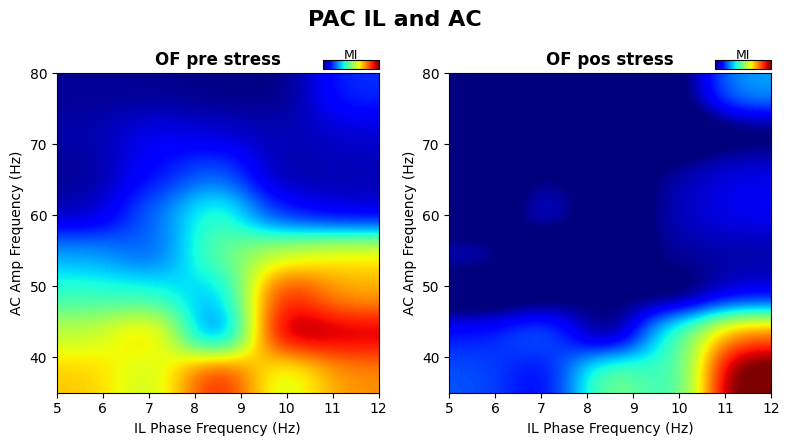

In [ ]:
# # pac parameters

vmin = 0.00003
vmax = 0.00014

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC IL and AC', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('IL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('IL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/figures/NOVO_CODIGO/PAC_IL_AC.jpeg')

> # ESPECTROGRAMAS

Spectrograms were computed using the complex wavelet transform scipy function, with signal.morlet2 parameter. The formula used to calculate the bandwidths was “widths = w * srate / (2 * freq *𝛑)”, where w is the constant central frequency (w = 12Hz). After computing each individual spectrogram, we averaged them to yield the mean spectrogram.

In [ ]:
data_prl_pre = []
data_prl_pos = []
data_cg_pre = []
data_cg_pos = []
data_il_pre = []
data_il_pos = []

for rato in ratos.keys():
  prl_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_PRL']

  data_prl_pre.append(prl_pre)

  prl_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_PRL']

  data_prl_pos.append(prl_pos)

  cg_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_CG']

  data_cg_pre.append(cg_pre)

  cg_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_CG']

  data_cg_pos.append(cg_pos)

  il_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_IL']

  data_il_pre.append(il_pre)

  il_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_IL']

  data_il_pos.append(il_pos)



# PRL_pre = np.mean(data_prl_pre, axis=0)
# PRL_pos = np.mean(data_prl_pos, axis=0)
# CG_pre = np.mean(data_cg_pre, axis=0)
# CG_pos = np.mean(data_cg_pos, axis=0)
# IL_pre = np.mean(data_il_pre, axis=0)
# IL_pos = np.mean(data_il_pos, axis=0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(data_prl_pre[0])/1000

90.0

In [ ]:
spectrogram_prl_pre = []
srate = 1000
w = 12.
freq = np.linspace(1, int(srate/2), int(srate/2))
widths = w*srate / (2*freq*np.pi)

for i in range(len(data_prl_pre)):
  spec = np.abs(signal.cwt(data_prl_pre[i], signal.morlet2, widths, w=w))
  spectrogram_prl_pre.append(spec)

spec_prl_pre = np.mean(spectrogram_prl_pre, axis = 0)

spectrogram_prl_pos = []
srate = 1000
w = 12.
freq = np.linspace(1, int(srate/2), int(srate/2))
widths = w*srate / (2*freq*np.pi)

for i in range(len(data_prl_pos)):
  spec_pos = np.abs(signal.cwt(data_prl_pos[i], signal.morlet2, widths, w=w))
  spectrogram_prl_pos.append(spec_pos)

spec_prl_pos = np.mean(spectrogram_prl_pos, axis = 0)

In [ ]:
len(spec_prl_pos)

500

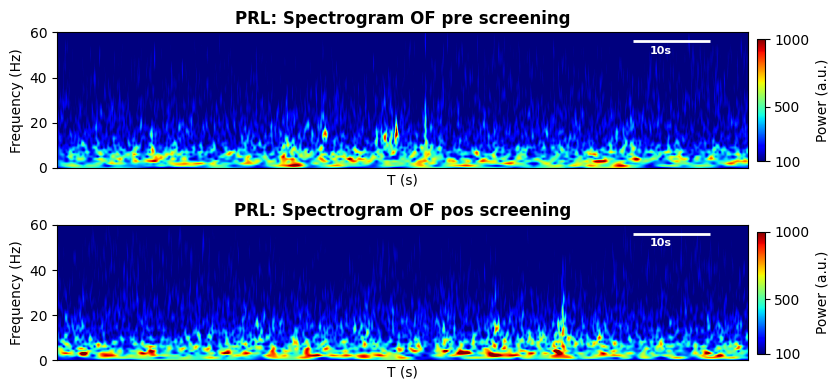

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(9, 4))
im = axs[0].imshow(spec_prl_pre, interpolation='gaussian', cmap='jet', vmin=100, vmax=1000, aspect='auto', alpha=1, label='Spectrogram')
axs[0].set_ylim([0, 60])
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('T (s)')
axs[0].set_xticks([])
axs[0].set_title('PRL: Spectrogram OF pre screening', fontweight='bold')


cbar = fig.colorbar(im, ax=axs[0], aspect=15, pad=0.01, shrink=0.9, location='right')
cbar.set_label('Power (a.u.)')
cbar.set_ticks([100,500, 1000])

axs[0].hlines(y=56, xmin=75000, xmax=85000, color='white', linewidth = 2)
axs[0].text(80000, 54, '10s', ha='right', va='top', color='white', fontweight = 'bold', fontsize = 8)

# subplot 2

im = axs[1].imshow(spec_prl_pos, interpolation='gaussian', cmap='jet', vmin=100, vmax=1000, aspect='auto', alpha=1, label='Spectrogram')
axs[1].set_ylim([0, 60])
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('T (s)')
axs[1].set_xticks([])
axs[1].set_title('PRL: Spectrogram OF pos screening', fontweight='bold')


cbar = fig.colorbar(im, ax=axs[1], aspect=15, pad=0.01, shrink=0.9, location='right')
cbar.set_label('Power (a.u.)')
cbar.set_ticks([100,500, 1000])


axs[1].hlines(y=56, xmin=75000, xmax=85000, color='white', linewidth = 2)
axs[1].text(80000, 54, '10s', ha='right', va='top', color='white', fontweight = 'bold', fontsize = 8)

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
plt.show()


In [ ]:
spectrogram_cg_pre = []
srate = 1000
w = 12.
freq = np.linspace(1, int(srate/2), int(srate/2))
widths = w*srate / (2*freq*np.pi)

for i in range(len(data_cg_pre)):
  spec = np.abs(signal.cwt(data_cg_pre[i], signal.morlet2, widths, w=w))
  spectrogram_cg_pre.append(spec)

spec_cg_pre = np.mean(spectrogram_cg_pre, axis = 0)

spectrogram_cg_pos = []
srate = 1000
w = 12.
freq = np.linspace(1, int(srate/2), int(srate/2))
widths = w*srate / (2*freq*np.pi)

for i in range(len(data_cg_pos)):
  spec_pos = np.abs(signal.cwt(data_cg_pos[i], signal.morlet2, widths, w=w))
  spectrogram_cg_pos.append(spec_pos)

spec_cg_pos = np.mean(spectrogram_cg_pos, axis = 0)

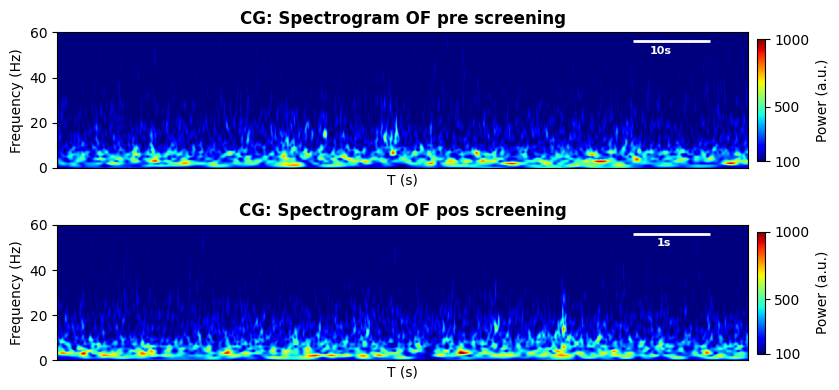

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(9, 4))
im = axs[0].imshow(spec_cg_pre, interpolation='gaussian', cmap='jet', vmin=100, vmax=1000, aspect='auto', alpha=1, label='Spectrogram')
axs[0].set_ylim([0, 60])
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('T (s)')
axs[0].set_xticks([])
axs[0].set_title('CG: Spectrogram OF pre screening', fontweight='bold')


cbar = fig.colorbar(im, ax=axs[0], aspect=15, pad=0.01, shrink=0.9, location='right')
cbar.set_label('Power (a.u.)')
cbar.set_ticks([100,500, 1000])

axs[0].hlines(y=56, xmin=75000, xmax=85000, color='white', linewidth = 2)
axs[0].text(80000, 54, '10s', ha='right', va='top', color='white', fontweight = 'bold', fontsize = 8)

# subplot 2

im = axs[1].imshow(spec_cg_pos, interpolation='gaussian', cmap='jet', vmin=100, vmax=1000, aspect='auto', alpha=1, label='Spectrogram')
axs[1].set_ylim([0, 60])
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('T (s)')
axs[1].set_xticks([])
axs[1].set_title('CG: Spectrogram OF pos screening', fontweight='bold')


cbar = fig.colorbar(im, ax=axs[1], aspect=15, pad=0.01, shrink=0.9, location='right')
cbar.set_label('Power (a.u.)')
cbar.set_ticks([100,500, 1000])


axs[1].hlines(y=56, xmin=75000, xmax=85000, color='white', linewidth = 2)
axs[1].text(80000, 54, '1s', ha='right', va='top', color='white', fontweight = 'bold', fontsize = 8)

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
plt.show()

> # COHERENCE

In [ ]:
coher_prl_cg_pre = []
coher_prl_il_pre = []
coher_cg_il_pre = []
coher_prl_cg_pos = []
coher_prl_il_pos = []
coher_cg_il_pos = []




for rato in ratos.keys():
    f,cx_pre = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_PRL'][0:11028], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_CG'][0:11028], fs = 1000,nperseg = 1000, noverlap = (int(0.9*1000)), nfft = 10*1000)
    coher_prl_cg_pre.append(cx_pre)

    f,cxx_pre = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_PRL'][0:11028], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_IL'][0:11028], fs = 1000,nperseg = 1000, noverlap = (int(0.9*1000)), nfft = 10*1000)
    coher_prl_il_pre.append(cxx_pre)

    f,cxxx_pre = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_CG'][0:11028], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_IL'][0:11028], fs = 1000,nperseg = 1000, noverlap = (int(0.9*1000)), nfft = 10*1000)
    coher_cg_il_pre.append(cxxx_pre)

    f,cx_pos = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_PRL'][0:11028], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_CG'][0:11028], fs = 1000,nperseg = 1000, noverlap = (int(0.9*1000)), nfft = 10*1000)
    coher_prl_cg_pos.append(cx_pos)

    f,cxx_pos = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_PRL'][0:11028], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_IL'][0:11028], fs = 1000,nperseg = 1000, noverlap = (int(0.9*1000)), nfft = 10*1000)
    coher_prl_il_pos.append(cxx_pos)

    f,cxxx_pos = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_CG'][0:11028], df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_IL'][0:11028], fs = 1000,nperseg = 1000, noverlap = (int(0.9*1000)), nfft = 10*1000)
    coher_cg_il_pos.append(cxxx_pos)

df_coher_pre = pd.DataFrame({'coher_prl_cg':np.mean(coher_prl_cg_pre,axis = 0), 'coher_prl_il':np.mean(coher_prl_il_pre,axis = 0),  'coher_cg_il':np.mean(coher_cg_il_pre,axis = 0)})
df_coher_pos = pd.DataFrame({'coher_prl_cg':np.mean(coher_prl_cg_pos,axis = 0), 'coher_prl_il':np.mean(coher_prl_il_pos,axis = 0),  'coher_cg_il':np.mean(coher_cg_il_pos,axis = 0)})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 10.0)

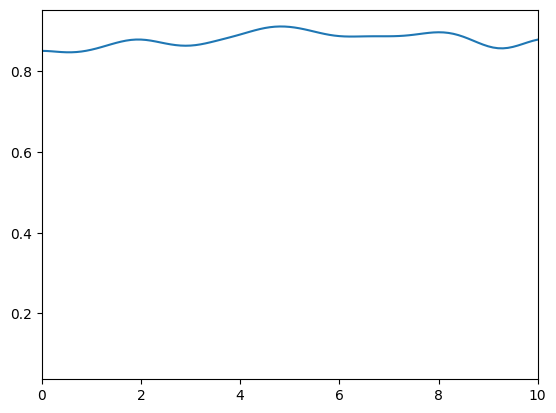

In [ ]:
plt.plot( f, df_coher_pre['coher_prl_cg'] )
plt.xlim(0,10)

> ## rascunhos

In [ ]:
delta_power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 4 )]['mean_power_prl'])
delta_power_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 4 )]['mean_power_prl'])

delta_power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 4 )]['mean_power_cg'])
delta_power_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 4 )]['mean_power_cg'])

In [ ]:
#beta
beta_power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 10 ) & (df_welch_pre['f'] <= 30 )]['mean_power_prl'])
beta_power_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 10 ) & (df_welch_pos['f'] <= 30 )]['mean_power_prl'])

beta_power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 10 ) & (df_welch_pre['f'] <= 30 )]['mean_power_cg'])
beta_power_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 10 ) & (df_welch_pos['f'] <= 30 )]['mean_power_cg'])

#low_gamma
lowgamma_power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 30 ) & (df_welch_pre['f'] <= 50 )]['mean_power_prl'])
lowgamma_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 30 ) & (df_welch_pos['f'] <= 50 )]['mean_power_prl'])

lowgamma_power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 30 ) & (df_welch_pre['f'] <= 50 )]['mean_power_cg'])
lowgamma_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 30 ) & (df_welch_pos['f'] <= 50 )]['mean_power_cg'])

#high_gamma
highgamma_power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 80 ) & (df_welch_pre['f'] <= 110 )]['mean_power_prl'])
highgamma_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 80 ) & (df_welch_pos['f'] <= 110 )]['mean_power_prl'])

highgamma_power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 80 ) & (df_welch_pre['f'] <= 110 )]['mean_power_cg'])
highgamma_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 80 ) & (df_welch_pos['f'] <= 110 )]['mean_power_cg'])

In [ ]:
import numpy as np
from scipy.stats import chi2

def bicoherence_significance_test(bicoherence_matrix, num_samples, significance_level):
    num_freqs = bicoherence_matrix.shape[0]

    # Define a matriz de resultado do teste de significância
    significance_matrix = np.zeros((num_freqs, num_freqs))

    # Define o valor crítico do teste de qui-quadrado
    critical_value = chi2.ppf(1 - significance_level, 2)

    # Realiza o teste de significância para cada par de frequências
    for i in range(num_freqs):
        for j in range(num_freqs):
            bicoherence_val = bicoherence_matrix[i, j]
            test_statistic = num_samples * bicoherence_val
            if test_statistic >= critical_value:
                significance_matrix[i, j] = 1

    return significance_matrix

# Exemplo de uso
# Suponha que você já tenha calculado a matriz de bicoerência e armazenado em 'bicoherence_matrix'
# num_samples é o número de amostras utilizadas para calcular a matriz de bicoerência
# significance_level é o nível de significância desejado (p = 0.05)

# Chamada da função para realizar o teste de significância
result = bicoherence_significance_test(df_coher['mean_coher_pre'], num_samples, 0.05)

# A matriz 'result' terá o mesmo tamanho da matriz de bicoerência,
# onde o valor 1 indica significância estatística e 0 indica não significância.


KeyError: ignored

In [ ]:
prl_list = []
cg_list = []

for rato in ratos.keys():
  prl = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_PRL'][0:11028]
  cg = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_CG'][0:11028]
  prl_list.append(prl)
  cg_list.append(cg)

df_data_bicoh = pd.DataFrame({'mean_prl_pre':np.mean(prl_list,axis = 0), 'mean_cg_pre':np.mean(cg_list,axis = 0)})

In [ ]:
import numpy as np
from scipy.signal import csd

x = np.array(df_data_bicoh['mean_prl_pre'])
y = np.array(df_data_bicoh['mean_cg_pre'])
freqs, csd_values = csd(x, y, fs=1000, window='hamming', nperseg=500, noverlap=250)

plt.imshow(csd_values, aspect='auto', origin='lower', extent=[freqs.min(), freqs.max(), freqs.min(), freqs.max()])
plt.colorbar(label='Bicoherence')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency (Hz)')
plt.title('Bicoherence')
plt.show()


In [ ]:
prl_pre_power = ( df_welch_pre['mean_power_prl'])
error_prl_pre = (np.std(prl_pre_power)) /np.sqrt(2)

cg_pre_power= ( df_welch_pre['mean_power_cg'])
error_cg_pre = (np.std(cg_pre_power)) /np.sqrt(2)

rasucnho theta

In [ ]:
#THETA POWER SPECTRA PRE OF AND COHERENCE
theta_power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 30 )]['mean_power_prl'])
theta_power_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 30 )]['mean_power_prl'])

theta_power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 30 )]['mean_power_cg'])
theta_power_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 1 ) & (df_welch_pos['f'] <= 30 )]['mean_power_cg'])


In [ ]:
from scipy.stats import ttest_ind
teste = ttest_ind(theta_power_prl_pre, theta_power_cg_pre)
teste

In [ ]:
teste = ttest_ind(theta_power_prl_pos, theta_power_cg_pos)
teste

In [ ]:
figura = plt.figure(figsize = (10,4))
# figura.subplots_adjust(hspace=0.5)
# figura.suptitle('Power Spectral Density: OF pre and pos screening', fontweight ="bold", fontsize = 12, x=0.3, y=1)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])

gs = gridspec.GridSpec(1, 2) # width_ratios=[0.7, 0.7, 0.7, 0.7])

ax1 = figura.add_subplot(gs[0, 0])
ax1.text(-0.15, 1.05, "A", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

x = df_welch_pre[(df_welch_pre['f'] >= 1) & (df_welch_pre['f'] <= 30)]['f']
y_prl = 10 * np.log10(theta_power_prl_pre )
std = np.std(y_prl)/np.sqrt(2)  # Cálculo do desvio padrão

x_pos = df_welch_pos[(df_welch_pos['f'] >= 1) & (df_welch_pos['f'] <= 30)]['f']
y_pos_prl = 10 * np.log10(theta_power_prl_pos)
std_pos = np.std(y_pos_prl)/np.sqrt(2)

plt.plot(x, y_prl, linewidth=1.5, color='black', label='PSD pre-screening')
plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='PSD pos-screening')
plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=8, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(1,30)
plt.ylim(20,40)
plt.title('PRL PSD', fontweight='bold',  pad = 8, fontsize = 10)
plt.yticks([20, 25, 30, 35, 40])

ax2 = figura.add_subplot(gs[0, 1])
ax2.text(-0.15, 1.05, "B", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

x = df_welch_pre[(df_welch_pre['f'] >= 1 ) & (df_welch_pre['f'] <= 30 )]['f']
y_cg = 10 * np.log10(theta_power_cg_pre )
std = np.std(y_cg)/np.sqrt(2)  # Cálculo do desvio padrão

x_pos = df_welch_pos[(df_welch_pos['f'] >= 1) & (df_welch_pos['f'] <= 30)]['f']
y_pos_cg = 10 * np.log10(theta_power_cg_pos)
std_pos = np.std(y_pos_cg)/np.sqrt(2)


plt.plot(x, y_cg, linewidth=1.5, color='black', label='PSD pre-screening')
plt.fill_between(x, y_cg - std, y_cg + std, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='PSD pos-screening')
plt.fill_between(x_pos, y_pos_cg - std_pos, y_pos_cg + std_pos, color='darkblue', alpha=0.15, edgecolor=None)
plt.title('CG PSD', fontweight='bold',  pad = 8, fontsize = 10)

plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=8, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(1,30)
plt.ylim(20,40)
plt.yticks([20, 25, 30, 35, 40])


In [ ]:
stat_prl_pre_pos = sp.stats.ttest_rel(theta_power_prl_pre, theta_power_prl_pos, alternative = 'less')
stat_prl_pre_pos

# The paired t-test was conducted to compare the means of PRL PSD after and before stress exposure. The test revealed a significant difference (t(290) = -4.70, p < 0.001), indicating that PRL PSD after the stress had significantly lower values than PSD before.

In [ ]:
stat_prl_pre_pos = sp.stats.ttest_rel(theta_power_cg_pre, theta_power_cg_pos, alternative = 'less')
stat_prl_pre_pos

In [ ]:
#THETA POWER SPECTRA PRE OF AND COHERENCE
theta_power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 8 ) & (df_welch_pre['f'] <= 30 )]['mean_power_prl'])
theta_power_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 8 ) & (df_welch_pos['f'] <= 30 )]['mean_power_prl'])

theta_power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 8 ) & (df_welch_pre['f'] <= 30 )]['mean_power_cg'])
theta_power_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 8 ) & (df_welch_pos['f'] <= 30 )]['mean_power_cg'])

In [ ]:
teste = ttest_ind(theta_power_prl_pos, theta_power_cg_pos)
teste

In [ ]:
figura = plt.figure(figsize = (10,4))
# figura.subplots_adjust(hspace=0.5)
# figura.suptitle('Power Spectral Density: OF pre and pos screening', fontweight ="bold", fontsize = 12, x=0.3, y=1)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])

gs = gridspec.GridSpec(1, 2) # width_ratios=[0.7, 0.7, 0.7, 0.7])

ax1 = figura.add_subplot(gs[0, 0])
ax1.text(-0.15, 1.05, "E", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

x = df_welch_pre[(df_welch_pre['f'] >= 8) & (df_welch_pre['f'] <= 30)]['f']
y_prl = 10 * np.log10(theta_power_prl_pre )
std = np.std(y_prl)/np.sqrt(2)  # Cálculo do desvio padrão

x_pos = df_welch_pos[(df_welch_pos['f'] >= 8) & (df_welch_pos['f'] <= 30)]['f']
y_pos_prl = 10 * np.log10(theta_power_prl_pos)
std_pos = np.std(y_pos_prl)/np.sqrt(2)

plt.plot(x, y_prl, linewidth=1.5, color='black', label='PSD pre-screening')
plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='PSD pos-screening')
plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=8, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(8,30)
# plt.ylim(20,40)
plt.title('PRL alpha/beta PSD', fontweight='bold',  pad = 8, fontsize = 10)
plt.ylim(25,40)
plt.yticks([ 25,30, 35, 40])

ax2 = figura.add_subplot(gs[0, 1])
ax2.text(-0.15, 1.05, "F", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

x = df_welch_pre[(df_welch_pre['f'] >= 8 ) & (df_welch_pre['f'] <= 30 )]['f']
y_cg = 10 * np.log10(theta_power_cg_pre )
std = np.std(y_cg)/np.sqrt(2)  # Cálculo do desvio padrão

x_pos = df_welch_pos[(df_welch_pos['f'] >= 8) & (df_welch_pos['f'] <= 30)]['f']
y_pos_cg = 10 * np.log10(theta_power_cg_pos)
std_pos = np.std(y_pos_cg)/np.sqrt(2)


plt.plot(x, y_cg, linewidth=1.5, color='black', label='PSD pre-screening')
plt.fill_between(x, y_cg - std, y_cg + std, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='PSD pos-screening')
plt.fill_between(x_pos, y_pos_cg - std_pos, y_pos_cg + std_pos, color='darkblue', alpha=0.15, edgecolor=None)
plt.title('CG alpha/beta PSD', fontweight='bold',  pad = 8, fontsize = 10)

plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=8, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(8,30)
plt.ylim(25,40)
plt.yticks([ 25,30, 35, 40])

In [ ]:
stat_prl_pre_pos = sp.stats.ttest_rel(theta_power_cg_pre, theta_power_cg_pos, alternative = 'less')
stat_prl_pre_pos

In [ ]:
stat_prl_pre_pos = sp.stats.ttest_rel(theta_power_prl_pre, theta_power_prl_pos, alternative = 'less')
stat_prl_pre_pos

In [ ]:
theta_power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 8 ) & (df_welch_pre['f'] <= 30 )]['mean_power_prl'])
theta_power_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 8 ) & (df_welch_pos['f'] <= 30 )]['mean_power_prl'])

theta_power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 5 ) & (df_welch_pre['f'] <= 8 )]['mean_power_cg'])
theta_power_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 5 ) & (df_welch_pos['f'] <= 8 )]['mean_power_cg'])

In [ ]:
stat_prl_pre_pos = sp.stats.ttest_rel(theta_power_cg_pre, theta_power_cg_pos, alternative = 'less')
stat_prl_pre_pos

In [ ]:
plt.figure(figsize = (5,5))
data = ([np.log(np.array(theta_power_prl_pre)), np.log(np.array(theta_power_prl_pos))])
labels = ['PRL->CG', 'CG->PRL']
plt.grid(color='grey', linestyle='--', linewidth=0.7 ,alpha = 0.1, axis = 'both', which = 'Both')
plt.bar(  labels, data, width=0.6, color=['darkred', 'darkblue'], alpha = 0.6, align='center')

plt.ylabel('Granger Causality')
# plt.xlim(-1,2)
# plt.ylim(0 ,4)

plt.plot([0, 1], [3.6, 3.6], 'k-', linewidth=1.5)

# Colocar asteriscos em cima da linha
plt.text(0.5, 3.65, '* * *', color='k', fontsize=12, horizontalalignment='center')

plt.show()

rascunhos

In [ ]:
s
ax1 = plt.subplot(111)

x_cg = df_welch_pre[(df_welch_pre['f'] >= 4 ) & (df_welch_pre['f'] <= 12 )]['f']
y_cg = 10 * np.log10(theta_power_cg_pre )
std_cg = np.std(y_cg)/np.sqrt(2)

x = df_welch_pre[(df_welch_pre['f'] >= 4) & (df_welch_pre['f'] <= 12)]['f']
y = 10 * np.log10(theta_power_prl_pre )
std = np.std(y)/np.sqrt(2)  # Cálculo do desvio padrão

plt.plot(x, y, linewidth=1.5, color='darkred', label='Theta power PRL ')
plt.fill_between(x, y - std, y + std, color='darkred', alpha=0.1,  edgecolor=None)

plt.plot(x_cg, y_cg, linewidth=1.5, color='darkblue', label='Theta power CG ')
plt.fill_between(x_cg, y_cg - std_cg, y_cg + std_cg, color='darkblue', alpha=0.1,  edgecolor=None)

plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.1, axis = 'both', which = 'both')
plt.legend(loc='lower left', fontsize = 10, frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB)')
plt.xlim(4,12)
ax2 = ax1.twinx()

ax2.plot(f,df_coher['mean_coher_pre'], label = 'Coherence PRL-CG', color = 'darkolivegreen')

ax = plt.gca()
ax.spines['right'].set_color('darkolivegreen') #colocando os limites da direita d grafico(escala da coher) em azul
ax.tick_params(axis='y', colors='darkolivegreen')
ax.spines['right'].set_linewidth(1.2)

plt.legend(loc='upper right', fontsize = 8, frameon=False)
plt.title('PRL - CG Power Spectra and Coherence: OF pre screening', fontsize = 12, fontweight = 'bold', pad = 15)
plt.ylabel('Coherence', color = 'darkolivegreen')
plt.xlim(4,12)
plt.tight_layout()

In [ ]:
theta_power_prl_pre = ( df_welch_pre[(df_welch_pre['f'] >= 4 ) & (df_welch_pre['f'] <= 12 )]['mean_power_prl'])
theta_power_prl_pos = ( df_welch_pos[(df_welch_pos['f'] >= 4 ) & (df_welch_pos['f'] <= 12 )]['mean_power_prl'])

theta_power_cg_pre = ( df_welch_pre[(df_welch_pre['f'] >= 4 ) & (df_welch_pre['f'] <= 12 )]['mean_power_cg'])
theta_power_cg_pos = ( df_welch_pos[(df_welch_pos['f'] >= 4 ) & (df_welch_pos['f'] <= 12 )]['mean_power_cg'])